In [1]:
# MLFA Assignment 6
# Rohit Ranjan
# 20CS30066

In [2]:
#  import commands

import scipy.spatial
from scipy import stats
import numpy as np
import statistics
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Iterable
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

/home/tfjuror/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  # Remove the CWD from sys.path while we load stuff.


In [3]:
# loading csv
df = pd.read_csv('Twitter_data.csv')

# dropping rows with NaN
df = df.dropna(axis=0)

# shuffling dataframe
df = df.sample(frac=1)

/home/tfjuror/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,3,4,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# converting categorical to numerical
col_4 = {False: 0, True: 1}
col_3 = {'en': 0, '_u': 1}
days ={'Friday':1, 'Saturday':2, 'Sunday':3, 'Thursday':0}

df.iloc[:,4] = df.iloc[:,4].map(col_4)
df.iloc[:,3] = df.iloc[:,3].map(col_3)
df.iloc[:,1] = df.iloc[:,1].map(days)

In [5]:
# train test split 90%-10%
df_test = df[-int(0.1*len(df)):]
df = df[:-int(0.1*len(df))]
print("Test set :",len(df))
print("Train set :",len(df_test))

Test set : 898
Train set : 99


In [6]:
# droppping non-required columns
X_columns = [ ' Hour', ' Lang', ' IsReshare', ' Reach',
       ' RetweetCount', ' Likes', ' Sentiment', ' LocationID']
Y_columns = ['Day']

X = df[X_columns]
X.columns = X_columns
Y = df[Y_columns]

X_test = df_test[X_columns]
X_test.columns = X_columns
Y_test = df_test[Y_columns]

In [7]:
print(X.shape)
print(Y.shape)

(898, 8)
(898, 1)


In [8]:
# utility function to flatten nested lists
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

In [9]:
# utility function to find euclidean distance
def euclidean_dist(x,y):
    return np.sqrt(np.sum(np.square(x-y)))

In [10]:
# mutual distances array calculated only once very efficiently
dist_arr = scipy.spatial.distance.cdist(X,X)
for i in range(len(X)):
    dist_arr[i,i]=1e9

In [11]:
# dictionary to store our dendogram
levels = {}

In [12]:
# initialising all data points as separate clusters
clusters =[]
for i in range(len(X)):
    clusters.append([i])
levels[str(len(clusters))] = clusters.copy()

In [13]:
# calculating the complete tree with complete linkage
def generator():
    while len(clusters)>1:
        yield

for _ in tqdm(generator()):
    curr_arr = np.zeros((len(clusters),len(clusters)))
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if(i==j):
                curr_arr[i,j]=1e9
                continue
            max=0
            for idx_i in clusters[i]:
                for idx_j in clusters[j]:
                    if(max<dist_arr[idx_i,idx_j] and dist_arr[idx_i,idx_j]!=1e9):
                        max=dist_arr[idx_i,idx_j]
            curr_arr[i,j]=max
    
    prev_clusters = clusters.copy()
    i,j = np.argwhere(curr_arr == np.min(curr_arr))[0]
    clusters.pop(i)
    if(i!=j):
        if(i>j):
            clusters.pop(j)
        else:
            clusters.pop(j-1)
    clusters.append(list(flatten([prev_clusters[i],prev_clusters[j]])))
    
    levels[str(len(clusters))] = clusters.copy()

897it [09:41,  1.54it/s]


In [14]:
# choose a level to cut
level_cut = 100

In [15]:
clusters = levels[str(level_cut)]
labels_list=[]
for cluster in clusters:
    labels = np.array([Y.iloc[i,0] for i in cluster])
    label = stats.mode(labels)[0]
    labels_list.append(label)

In [16]:
# utility function for train accuracy
def train_accuracy(X,Y,clusters,labels_list):
    correct=0
    for k,cluster in enumerate(clusters):
        for idx in cluster:
            if(Y.iloc[idx,0]==labels_list[k]):
                correct+=1
    return correct/len(X)

In [17]:
# utility function for test accuracy
def test_accuracy(X_test,Y_test,X,Y,clusters,labels_list):
    correct=0
    cluster_centres=[]
    label_map = np.zeros((len(X),))
    pred_labels=[]
    for k,cluster in enumerate(clusters):
        arr = np.array([X.iloc[idx,:] for idx in cluster])
        mean = np.mean(arr,axis=0)
        cluster_centres.append(mean)
        for idx in cluster:
            label_map[idx]=labels_list[k]
    test_dist = scipy.spatial.distance.cdist(X_test,X)
    for i in range(len(X_test)):
        closest = np.argmin(np.array(test_dist[i]))
        pred_labels.append(label_map[closest])
        if(label_map[closest]==Y_test.iloc[i,0]):
            correct+=1
    return correct/len(X_test),pred_labels,label_map,cluster_centres

In [18]:
print('Train Accuracy: ',train_accuracy(X,Y,clusters,labels_list))

Train Accuracy:  0.49665924276169265


In [19]:
test_acc,pred_labels,label_map,cluster_centres = test_accuracy(X_test,Y_test,X,Y,clusters,labels_list)
print('Test Accuracy: ',test_acc)

Test Accuracy:  0.46464646464646464


In [20]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
model = model.fit(X,Y)

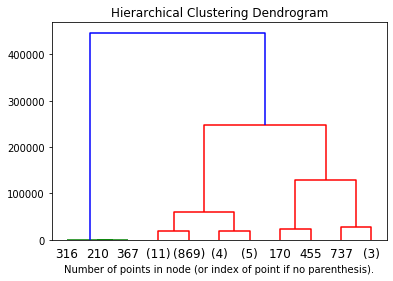

In [21]:
# Visualising the Dendogram
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [22]:
# We can see that our clusters are the exact same as the scipy package
print(levels['3'])

[[316, 210, 367], [781, 11, 485, 49, 682, 94, 506, 605, 635, 186, 824, 333, 627, 7, 256, 338, 5, 521, 227, 480, 714, 269, 831, 481, 747, 771, 330, 788, 61, 564, 808, 99, 237, 276, 679, 757, 561, 740, 855, 570, 883, 37, 324, 728, 208, 475, 755, 670, 158, 164, 16, 311, 407, 622, 300, 103, 182, 172, 368, 299, 630, 872, 652, 871, 307, 658, 701, 448, 216, 723, 825, 787, 797, 861, 130, 612, 105, 343, 119, 403, 69, 739, 803, 273, 743, 364, 661, 556, 223, 389, 194, 310, 571, 618, 433, 668, 549, 809, 865, 587, 847, 45, 621, 278, 304, 468, 193, 830, 6, 243, 463, 706, 91, 834, 515, 711, 484, 851, 731, 27, 139, 323, 283, 765, 357, 151, 285, 68, 545, 684, 187, 189, 272, 849, 51, 201, 428, 270, 390, 558, 221, 434, 859, 154, 596, 426, 581, 282, 687, 144, 231, 277, 659, 106, 228, 134, 253, 75, 710, 889, 22, 888, 814, 88, 378, 811, 449, 828, 569, 577, 801, 738, 592, 784, 796, 26, 777, 866, 841, 870, 96, 232, 527, 647, 58, 113, 137, 474, 626, 707, 13, 555, 81, 59, 97, 508, 510, 29, 541, 438, 595, 813, 3

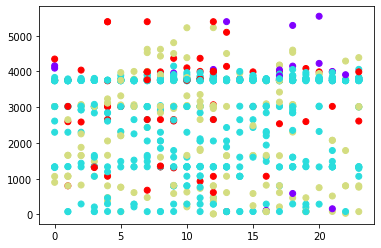

In [23]:
# Scatter plot of 0th and 7th attribute along with predicted labels for train set
plt.scatter(X.iloc[:,0],X.iloc[:,7],c=label_map,cmap='rainbow')
plt.show()

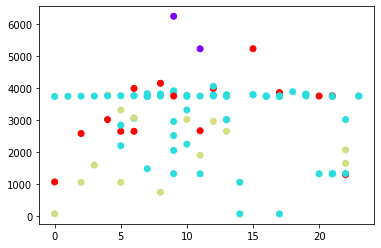

In [24]:
# Scatter plot of 0th and 7th attribute along with predicted labels for test set
plt.scatter(X_test.iloc[:,0],X_test.iloc[:,7],c=pred_labels,cmap='rainbow')
plt.show()

In [25]:
X_test_dist = [euclidean_dist(X_test.iloc[i,:],np.mean(X,axis=0)) for i in range(len(X_test))]
X_dist = [euclidean_dist(X.iloc[i,:],np.mean(X,axis=0)) for i in range(len(X))]

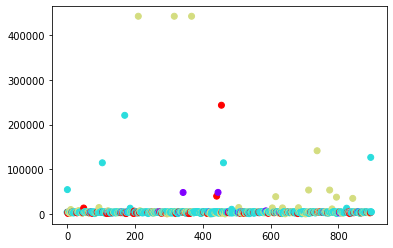

In [26]:
# Scatter plot of distance of datapoint from mean along with predicted labels for train set
plt.scatter([i for i in range(len(X))],X_dist,c=label_map,cmap='rainbow')
plt.show()

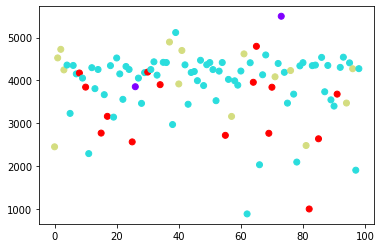

In [27]:
# Scatter plot of distance of datapoint from mean along with predicted labels for test set
plt.scatter([i for i in range(len(X_test))],X_test_dist,c=pred_labels,cmap='rainbow')
plt.show()